# Testing QCBM concept 1

The rationale behind this test is to split a time-series dataset of numbers from 1-10 into 10 subsections, a QCBM will be responsible for learning the distribution of each subset. By sampling each synthetic distribution, we can see if the original distribution is learnt to an acceptable degree

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from braket.circuits import Circuit, FreeParameter, Gate, Observable
from braket.devices import LocalSimulator
import pandas as pd
import os

In [123]:
from numpy import genfromtxt
data = genfromtxt('numberssimple.csv', delimiter=',')

# Split the data into sets of 10 
data = np.array_split(data, 20)
print(data)


[array([[nan, nan]]), array([[0., 0.]]), array([[1., 1.]]), array([[2., 2.]]), array([[3., 3.]]), array([[4., 4.]]), array([[5., 5.]]), array([[6., 6.]]), array([[7., 7.]]), array([[8., 8.]]), array([[9., 9.]]), array([], shape=(0, 2), dtype=float64), array([], shape=(0, 2), dtype=float64), array([], shape=(0, 2), dtype=float64), array([], shape=(0, 2), dtype=float64), array([], shape=(0, 2), dtype=float64), array([], shape=(0, 2), dtype=float64), array([], shape=(0, 2), dtype=float64), array([], shape=(0, 2), dtype=float64), array([], shape=(0, 2), dtype=float64)]


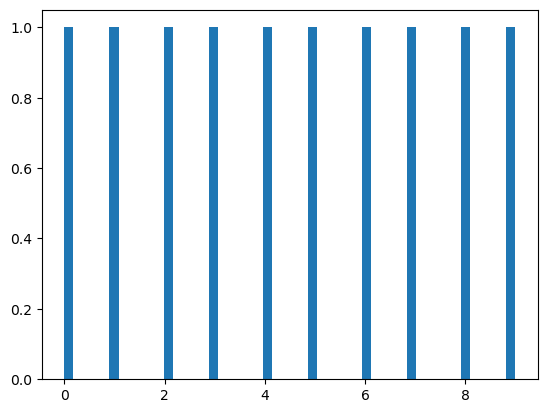

In [124]:

path = "numberssimple.csv"
D = pd.read_csv(path)  

#D = df[['theo_event_tx_timestamp','under']] 
feature = "value"
dmin = D[feature].min() # maximum value of the data
dmax = D[feature].max() # minimum value of the data
drange = dmax - dmin   # data range

data = D[feature].to_numpy()  # convert data to numpy array
plt.hist(data,bins=50)  # plot the data as a histogram
plt.show()

In [125]:
#dmin = data.min() # maximum value of the data
#dmax = data.max() # minimum value of the data
#drange = dmax - dmin # data range
# Fixing the max and min values of the data
dmin = 0
dmax = 9
drange = dmax - dmin

In [126]:
# function to convert data in the interval (vmin-epsilon,vmax+epsilon) into bitstring using 12-bit precision
def data_to_bitstring(value,vmin,vmax,epsilon=0,precision=4):
    int_value = int((value - vmin + epsilon)/((vmax-vmin)+2*epsilon)*(2**precision-1))
    bitstring = format(int_value,'04b')
    return bitstring

# convert bitstring of length precision to a data point in the range (vmin-epsilon,vmax+epsilon)
def bitstring_to_data(bitstring,vmin,vmax,epsilon=0):
    precision = len(bitstring)
    bitstring = bitstring[::-1]
    vint = 0
    for j in range(precision):
        vint += int(bitstring[j])*(2**j)  # obtain integer representation from the bitstring
    value = vmin - epsilon + vint/(2**precision-1)*(vmax - vmin + 2*epsilon) # bring into the range (vmin-epsilon,vmax+epsilon)
    return value

In [127]:
device = LocalSimulator()

In [128]:
# Construct the PQC (parameterized quantum circuit) ansatz for the Quantum Circuit Born Machine (QCBM)
qcbm = Circuit()
wires = 6 # number of wires corresponding to the bit precision required for the data, here 12 bits
depth = 7  # number of parametrised 1-qubit gate layers
theta = [[FreeParameter("t_%s_%s" % (l,q)) for q in range(wires)] for l in range(depth)]
# free parameters (angles) are labelled t_i_j, where i is the layer of the circuit and j the wire

for q in range(wires):
    qcbm.rx(q,theta[0][q])  # layer of rx gates with unspecified parameters
    qcbm.rz(q,theta[1][q])  # layer of rz gates with unspecified parameters

for q in range(wires//2):       ## layer of interlinked cnot gates for entanglement
    qcbm.cnot(control=2*q,target=(2*q+1)%wires)
for q in range(wires//2):
    qcbm.cnot(control=2*q+1,target=(2*(q+1))%wires)

for q in range(wires):
    qcbm.rz(q,theta[2][q]) # layer of rx gates with unspecified parameters
    qcbm.rx(q,theta[3][q]) # layer of rz gates with unspecified parameters
    qcbm.rz(q,theta[4][q]) # layer of rx gates with unspecified parameters

for q in range(wires//2):       ## layer of interlinked cnot gates for entanglement
    qcbm.cnot(control=wires-1-2*q,target=(wires-2*q)%wires)
for q in range(wires//2):
    qcbm.cnot(control=wires-2-2*q,target=wires-1-2*q)

for q in range(wires):
    qcbm.rz(q,theta[5][q])  # layer of rz gates with unspecified parameters
    qcbm.rx(q,theta[6][q])  # layer of rx gates with unspecified parameters

print(qcbm)

T  : │      0      │      1      │  2  │     3     │      4      │      5      │      6      │     7     │  8  │      9      │     10      │
      ┌───────────┐ ┌───────────┐             ┌───┐ ┌───────────┐ ┌───────────┐ ┌───────────┐ ┌───┐             ┌───────────┐ ┌───────────┐ 
q0 : ─┤ Rx(t_0_0) ├─┤ Rz(t_1_0) ├───●─────────┤ X ├─┤ Rz(t_2_0) ├─┤ Rx(t_3_0) ├─┤ Rz(t_4_0) ├─┤ X ├─────────●───┤ Rz(t_5_0) ├─┤ Rx(t_6_0) ├─
      └───────────┘ └───────────┘   │         └─┬─┘ └───────────┘ └───────────┘ └───────────┘ └─┬─┘         │   └───────────┘ └───────────┘ 
      ┌───────────┐ ┌───────────┐ ┌─┴─┐         │   ┌───────────┐ ┌───────────┐ ┌───────────┐   │         ┌─┴─┐ ┌───────────┐ ┌───────────┐ 
q1 : ─┤ Rx(t_0_1) ├─┤ Rz(t_1_1) ├─┤ X ├───●─────┼───┤ Rz(t_2_1) ├─┤ Rx(t_3_1) ├─┤ Rz(t_4_1) ├───┼─────●───┤ X ├─┤ Rz(t_5_1) ├─┤ Rx(t_6_1) ├─
      └───────────┘ └───────────┘ └───┘   │     │   └───────────┘ └───────────┘ └───────────┘   │     │   └───┘ └───────────┘ └───────────┘ 
      ┌──────

In [129]:
# generate random angles in the range (-pi,pi) to initialize the parameters of the QCBM
def random_thetas(m=7,dim=[6,7]):
# generate a random array of dimension 'size' each parameter can take m discrete values between -pi and +pi
    thetas = np.random.randint(2**m,size=dim)
    thetas = np.pi/2**(m-1) * thetas
    thetas -= np.pi
    return thetas

# Prepare dictionary from parameter values theta that can serve as input for the parameterized quantum circuit of the QCBM
def thetas_to_dict(thetas):
    wires, depth = thetas.shape
    theta_dict = {}
    for i in range(depth):
        for j in range(wires):
            t_str = 't_' + str(i) + '_' + str(j)
            theta_dict[t_str] = thetas[j][i]
    return theta_dict

In [130]:
def draw_data_sample(data,K=100):  # draws K samples randomly from the original data
    u = []                         # need these in the cost function to compare with the QCBM generated data below
    rows = len(data)
    for i in range(K):
        index = np.random.randint(rows)  # pick a random row index of the date array
        u.append(data[index])            # retrieve the data value at this index and append to u
    return u

In [131]:
def run_qcbm(Nthetas,vmin,vmax,epsilon=0,K=100): # samples K times from the QCBM for each set of parameters in Nthetas
    Nv = []                                      # array to hold N sets of samples from K shots each
    for thetas in Nthetas:
        thetas_dict = thetas_to_dict(thetas)
        task = device.run(qcbm,shots=K,inputs=thetas_dict)   # Here the quantum circuit is executed, incurring cost
        result = task.result()                               # get results of the measurements
        counts = result.measurement_counts                   # obtain bitstrings with their respective counts
        v = []
        for bitstring, count in counts.items():
            value = bitstring_to_data(bitstring,vmin,vmax,epsilon=epsilon)  # convert bitstring to real valued data
            for i in range(count):
                v.append(value)                                             # append each data as many times as it was measured
        Nv.append(v)
    return Nv

In [132]:
# cost function, defined as the sum of squared differences of K generated samples and samples drawn from the original data
def cost(u,v):
    K = len(u)
    u_sorted = np.sort(u)    # sort data by value
    v_sorted = np.sort(v)    # sort generated samples by value
    squared_diff_sum = 0     # compute the sum of squared differences between the sorted samples
    for i in range(K):
        squared_diff_sum += (u_sorted[i]-v_sorted[i])**2  # add the squared difference for each data / sample pair
    return squared_diff_sum  # return the sum of squared differences

In [133]:
# To find good parameter values by running a genetic algorithm, this function performs one mutation step
# Mutation works by creating D copies of each set of theta values in Mthetas and changing column entries with probability alpha
# return a list Nthetas of N=M*D sets of parameter values
def mutation(Mthetas,D,alpha,m=7):
    Nthetas_new = []
    for thetas in Mthetas:
        wires, depth = thetas.shape
        for d in range(D):            # for each set of theta values create D mutations, generating N = M*D mutations in total
            theta_trans = thetas.copy().transpose()  # make a copy of the current theta values which is to be mutated
            for i in range(depth):
                if np.random.rand() < alpha:                                 # with probability alpha perform a mutation
                    wire = np.random.randint(wires)                          # select a random wire
                    angle = np.random.randint(2**m)*np.pi/(2**(m-1)) - np.pi # generate a random angle in (-pi,pi) in 2**m steps
                    theta_trans[i][wire] = angle                             # replace angle in the chosen wire
                    if np.random.rand() < alpha/2:                         # perform a second mutation with probability alpha/2
                        wire = np.random.randint(wires)                          # select a random wire (could be same as above)
                        angle = np.random.randint(2**m)*np.pi/(2**(m-1)) - np.pi # generate a random angle in (-pi,pi)
                        theta_trans[i][wire] = angle                         # replace angle in the chosen wire
            Nthetas_new.append(theta_trans.transpose())                      # append mutated theta values to parameter list
    return Nthetas_new

In [ ]:
# calculates the cost for all sets of theta values in Nthetas for the data by sampling the QCBM,
# returning the thetas sorted by cost
def thetas_by_cost(Nthetas,data,vmin,vmax,epsilon=0,K=100):
    u = draw_data_sample(data,K)                           # draw samples from the original data to compare with generated data
    Nv = run_qcbm(Nthetas,vmin,vmax,epsilon=epsilon,K=K)   # for each set of theta values, sample the QCBM K times
    cost_vector = []
    for v in Nv:                           # compute the cost function between the original data and each set of QCBM samples
        cost_vector.append(cost(u,v))
    cost_thetas = list(zip(cost_vector,Nthetas))
    cost_thetas.sort()                     # sort the list by the value of the cost function
    cost_sorted = [x for x,y in cost_thetas]
    Nthetas_sorted = [y for x,y in cost_thetas]
    return cost_sorted, Nthetas_sorted

In [ ]:
def training():
    # Train the parameters of the QCBM ansatz using a genetic algorithm
    L = 2  # number of iterations (generations) for the genetic algorithm
    M = 5  # number of best solutions in the given generation, chosen for further mutation
    D = 40  # number of 'offspring' each solution (1..M) produces through mutation
    N = D*M # number of solutions in each generation
    alpha, beta = 1.0, 0.013863 # mutation parameters
    kappa = 50 # number of generations after which mutation rate has decreased by a factor of 1/2
    epsilon = 0.01   # amount by which generated data can lie outside the range of original data: (vmin - epsilon,vmax + epsilon)
    #epsilon = 0

    # initialize N sets of theta values with random angles

    for i in range(N):
        Nthetas.append(random_thetas())

    # compute the cost for samples obtained from the QCBM and record the minimum
    cost_sorted, Nthetas_sorted = thetas_by_cost(Nthetas,data,dmin,dmax,epsilon=epsilon)
    print('Generation 0, cost = %.5f' % cost_sorted[0])
    cost_min = [cost_sorted[0]]

    # now run the genetic algorithm over L generations
    for gen in range(L):
        alpha *= np.exp(-beta)                # mutation probability alpha decreased exponentially (factor 1/2 for 50 generations)
        Mthetas = Nthetas_sorted[:M]          # keep only the best M sets of theta values
        Nthetas_new = mutation(Mthetas,D,alpha)
        cost_new, thetas_new = thetas_by_cost(Nthetas_new,data,dmin,dmax,epsilon=epsilon)
        message = 'Generation %i, cost = %.5f' % (gen+1, cost_new[0])
        if cost_new[0] < cost_min[-1]:        # if minimum cost of new parameters is less than previous minimum, keep them
            cost_min.append(cost_new[0])
            Nthetas_sorted = thetas_new
            print(message + '  improved!')    # print that parameters have improved
        else:
            print(message)

    return Nthetas_sorted

Generation 0, cost = 14.49186
Generation 1, cost = 15.20194
Generation 2, cost = 14.04607  improved!
Generation 3, cost = 16.10043
Generation 4, cost = 15.15853
Generation 5, cost = 15.98020
Generation 6, cost = 19.52611
Generation 7, cost = 14.62885
Generation 8, cost = 17.27765
Generation 9, cost = 18.36839
Generation 10, cost = 15.88069
Generation 11, cost = 16.32653
Generation 12, cost = 17.05790
Generation 13, cost = 14.06122
Generation 14, cost = 11.79725  improved!
Generation 15, cost = 28.27111
Generation 16, cost = 14.00182
Generation 17, cost = 13.08103
Generation 18, cost = 14.56005
Generation 19, cost = 14.36144
Generation 20, cost = 13.85805


In [ ]:
thetas_opt = training()[0]  # record the best values of theta parameters obtained from the genetic algorithm
np.savetxt("thetas_opt.csv",thetas_opt,delimiter=",") 

[5.43063492 2.42396825 3.85571429 0.56269841 0.56269841 7.00555556
 8.43730159 4.85793651 7.57825397 1.85126984]
[1.85126984 7.57825397 4.85793651 8.43730159 7.00555556 0.56269841
 0.56269841 3.85571429 2.42396825 5.43063492]


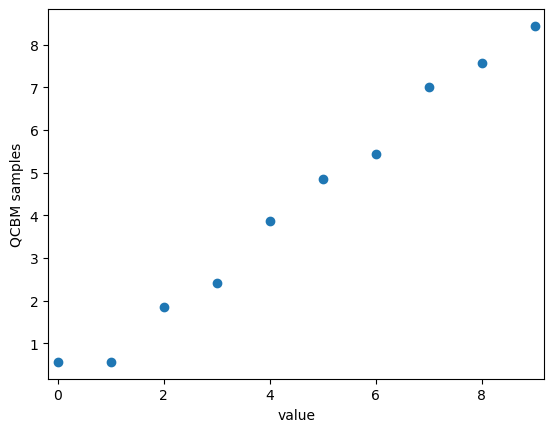

In [137]:
# create a QQ (quantile-quantile) plot of the two distributions (DAX log-returns and QCBM generated data)
# once a good set of theta parameters has been obtained and saved in "thetas_opt.csv", this section can be executed on its own
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot_2samples

thetas_opt = np.genfromtxt("thetas_opt.csv",delimiter=",") # load good theta parameters previously obtained to avoid
                                                         # having to run the training algorithm again
device = LocalSimulator()    # use simulator, below we will use actual quantum hardware
samples = np.array(run_qcbm([thetas_opt],dmin,dmax,epsilon=0.01 ,K=len(data))[0])

samples = samples[:100000]
print(samples)


#save samples to csv
np.savetxt("samples.csv",samples,delimiter=",")  # save good parameters to a csv file (only execute to override previous)

print(samples[::-1])
pp_x = sm.ProbPlot(data)  # probability plot of x-data
pp_y = sm.ProbPlot(samples)  # probabilily plot of y-data
qqplot_2samples(pp_x, pp_y,xlabel=feature,ylabel='QCBM samples')  # plot the two sets against one another
plt.show()

(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

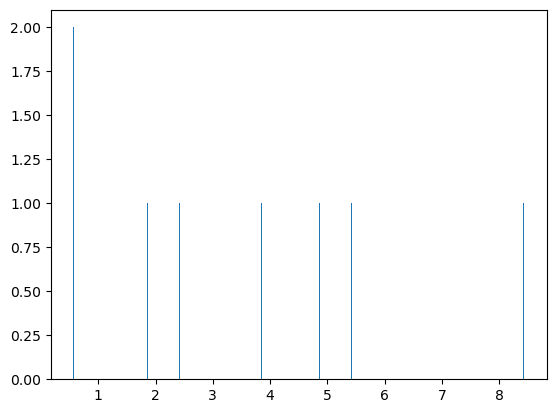

In [138]:
plt.hist(samples,bins=600)

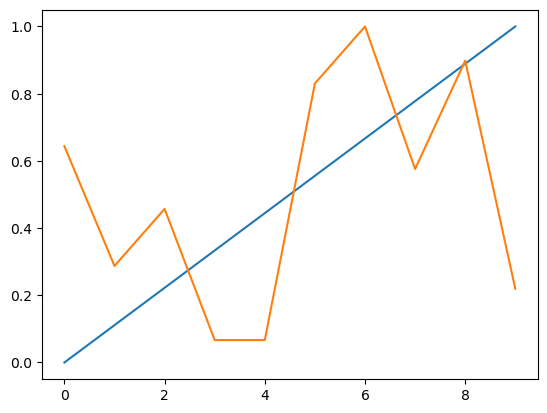

In [139]:

data = data/data.max()
samples = samples/samples.max()

plt.plot(data)
plt.plot(samples)
plt.show()